# Pre-Steps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import time
import uuid
import cv2

In [3]:
#function to load the fetched image into the tensor in bytes
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [4]:
#Image data augmentation is the process of generating new transformed versions of images from the given image dataset to increase its diversity
import albumentations as alb

In [5]:
#Setting up the albumentations' image augmentation by calling differentation albumentations' functions
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [6]:
#Loading an Image on which albumentations' results will be checked
img = cv2.imread(os.path.join('data','train', 'images','00c42162-8e7d-11ee-bc20-ed915af7da6d.jpg'))

In [7]:
#Loading the matching label of the above image
with open(os.path.join('data', 'train', 'labels', '00c42162-8e7d-11ee-bc20-ed915af7da6d.json'), 'r') as f:
    label = json.load(f)

In [8]:
label['shapes'][0]['points']

[[294.2690058479533, 2.2807017543859516], [639.0, 440.025117600071]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [9]:
#Extracting the coordinates of the above label fetched and storing them in an array
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [10]:
coords

[294.2690058479533, 2.2807017543859516, 639.0, 440.025117600071]

In [11]:
#In augmentor we used the albumentations as parameters' format for label, now converting the label's coordinates according to image width and height
coords = list(np.divide(coords, [640,480,640,480]))

In [12]:
coords

[0.459795321637427, 0.0047514619883040655, 0.9984375, 0.9167189950001479]

### 4.4 Apply Augmentations and View Results

In [13]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [14]:
augmented['bboxes'][0][2:]

(0.41495776478232604, 1.0)

In [15]:
augmented['bboxes']

[(0.0, 0.08216640533317554, 0.41495776478232604, 1.0)]

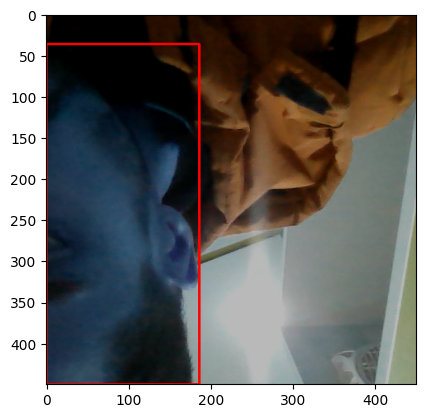

In [16]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [17]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(45):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [18]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [19]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [20]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [21]:
train_images.as_numpy_iterator().next()

array([[[0.2851103 , 0.27444854, 0.24503677],
        [0.29761028, 0.2893995 , 0.27193627],
        [0.28547794, 0.28302696, 0.27518383],
        ...,
        [0.7094976 , 0.8702819 , 0.8153799 ],
        [0.6985294 , 0.8593137 , 0.80441177],
        [0.69411767, 0.85490197, 0.8       ]],

       [[0.31764707, 0.3107843 , 0.31323528],
        [0.31770834, 0.31770834, 0.31770834],
        [0.33425245, 0.33425245, 0.33425245],
        ...,
        [0.70686275, 0.8661765 , 0.8117647 ],
        [0.7058824 , 0.8666667 , 0.8117647 ],
        [0.6910539 , 0.85245097, 0.7923407 ]],

       [[0.33952206, 0.33952206, 0.29442403],
        [0.33633578, 0.34025735, 0.3107843 ],
        [0.35588235, 0.35931373, 0.34074754],
        ...,
        [0.70980394, 0.85882354, 0.80784315],
        [0.70594364, 0.85496324, 0.80398285],
        [0.6990196 , 0.85655636, 0.79515934]],

       ...,

       [[0.05618872, 0.12971814, 0.2245098 ],
        [0.0783701 , 0.19650735, 0.30765933],
        [0.10882353, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [22]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [23]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [24]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [25]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.   , 0.   , 0.552, 0.957], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [27]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 855, 855, 810, 810)

### 7.2 Create Final Datasets (Images/Labels)

In [28]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [29]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1550)
test = test.batch(8)
test = test.prefetch(4)

In [30]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1250)
val = val.batch(8)
val = val.prefetch(4)

In [31]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1824, 0.    , 0.667 , 0.3013],
        [0.9907, 0.1022, 1.    , 0.7017],
        [0.3003, 0.0627, 0.6514, 0.6265],
        [0.    , 0.3987, 0.1936, 0.9365],
        [0.4197, 0.    , 0.88  , 0.6987],
        [0.4114, 0.2754, 0.5986, 0.5444],
        [0.2505, 0.2498, 0.514 , 0.65  ],
        [0.58  , 0.381 , 0.917 , 0.905 ]], dtype=float16))

### 7.3 View Images and Annotations

In [32]:
data_samples = train.as_numpy_iterator()

In [150]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


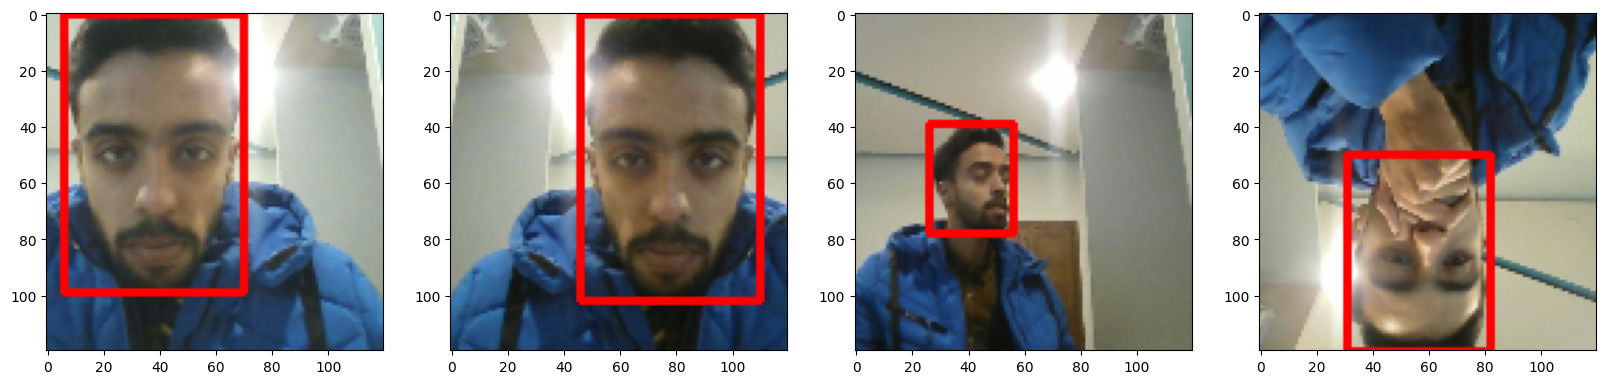

In [151]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [152]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [153]:
vgg = VGG16(include_top=False)

In [154]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [155]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [156]:
facetracker = build_model()

In [157]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [158]:
X, y = train.as_numpy_iterator().next()

In [159]:
X.shape

(8, 120, 120, 3)

In [160]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 541ms/step


In [161]:
classes, coords

(array([[0.5756153 ],
        [0.5223744 ],
        [0.52597016],
        [0.5208662 ],
        [0.59470034],
        [0.50638217],
        [0.52055985],
        [0.49708137]], dtype=float32),
 array([[0.715703  , 0.6349023 , 0.46557084, 0.72015524],
        [0.6498749 , 0.57601833, 0.4857908 , 0.67079294],
        [0.70473707, 0.5395345 , 0.5066933 , 0.70317733],
        [0.6203599 , 0.58668566, 0.404618  , 0.6872308 ],
        [0.72507036, 0.65177274, 0.41583303, 0.7092657 ],
        [0.6935493 , 0.59675324, 0.48344812, 0.5878041 ],
        [0.6754139 , 0.5690136 , 0.51598936, 0.76364946],
        [0.6555095 , 0.6455216 , 0.44488063, 0.69826615]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [162]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [163]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [164]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [165]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [166]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.9000564>

In [167]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6310589>

In [168]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.9000564>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [169]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [170]:
model = FaceTracker(facetracker)

In [171]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [172]:
logdir='logs'

In [173]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [174]:
hist = model.fit(train, epochs=70, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/70
473/473 [==============================] - 569s 1s/step - total_loss: 0.1920 - class_loss: 0.0347 - regress_loss: 0.1747 - val_total_loss: 0.0202 - val_class_loss: 7.3883e-05 - val_regress_loss: 0.0201
Epoch 2/70
473/473 [==============================] - 562s 1s/step - total_loss: 0.0387 - class_loss: 0.0065 - regress_loss: 0.0354 - val_total_loss: 0.0034 - val_class_loss: 1.9986e-04 - val_regress_loss: 0.0033
Epoch 3/70
473/473 [==============================] - 553s 1s/step - total_loss: 0.0156 - class_loss: 0.0033 - regress_loss: 0.0140 - val_total_loss: 0.8148 - val_class_loss: 1.4834 - val_regress_loss: 0.0731
Epoch 4/70
473/473 [==============================] - 616s 1s/step - total_loss: 0.0081 - class_loss: 2.1066e-04 - regress_loss: 0.0080 - val_total_loss: 0.0028 - val_class_loss: 9.2694e-05 - val_regress_loss: 0.0028
Epoch 5/70
473/473 [==============================] - 595s 1s/step - total_loss: 0.0105 - class_loss: 0.0027 - regress_loss: 0.0092 - val_total_loss

### 10.3 Plot Performance

In [175]:
hist.history

{'total_loss': [0.057334162294864655,
  0.01506243646144867,
  0.033456504344940186,
  0.0032308881636708975,
  0.0013466300442814827,
  0.0014274679124355316,
  0.0013237507082521915,
  0.0003519538149703294,
  0.0003837904951069504,
  0.0008070480544120073,
  0.0007317423587664962,
  0.0015926836058497429,
  0.0013197881635278463,
  0.000895795994438231,
  0.0021641175262629986,
  0.0009779887041077018,
  0.0011131411883980036,
  0.00044989341404289007,
  0.0005789186689071357,
  0.0007300261640921235,
  0.00019749363127630204,
  0.0008947913302108645,
  0.0007827556692063808,
  0.0006559228058904409,
  0.0001477270998293534,
  0.00023758431780152023,
  0.00022071794955991209,
  0.00037305691512301564,
  0.00044336036080494523,
  0.00016609125304967165,
  0.0002635419659782201,
  0.000664323044475168,
  8.621488814242184e-05,
  0.00022653078485745937,
  0.00021663185907527804,
  0.00014960784756112844,
  0.00011496677325339988,
  0.0001647116441745311,
  0.00013614595809485763,
  0.0

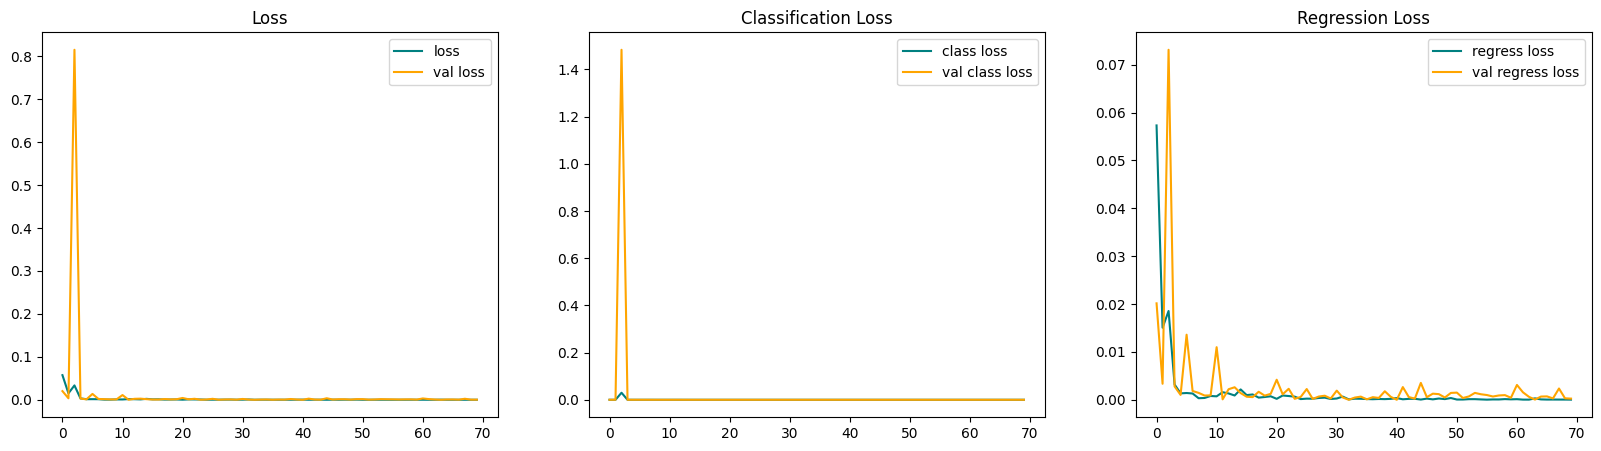

In [176]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [177]:
test_data = test.as_numpy_iterator()

In [178]:
test_sample = test_data.next()

In [179]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 625ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


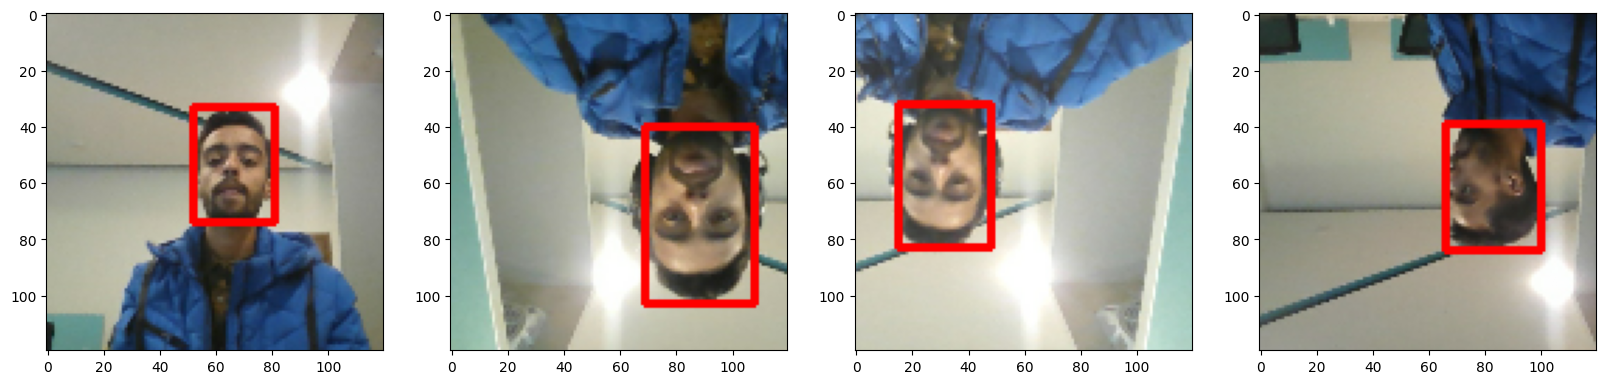

In [180]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### My Dummy Steps to Predict a sample image

In [1]:
# Crop the image using the coordinates of the rectangle
def crop(image, coords):
    # Get the coordinates of the top-left and bottom-right corners
    x1, y1, x2, y2 = coords
    # Get the width and height of the rectangle
    w = x2 - x1
    h = y2 - y1
    # Create a mask with the same size as the image
    mask = np.zeros(image.shape, dtype=np.uint8)
    # Draw a white rectangle on the mask
    # Draw a white rectangle on the mask
    cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), -1)
    # Copy the image using the mask
    cropped = cv2.copyMakeBorder(image, 0, 0, 0, 0, cv2.BORDER_REPLICATE, mask=mask)
    # Return the cropped image
    return cropped

1/1 [==============================] - 0s 455ms/step


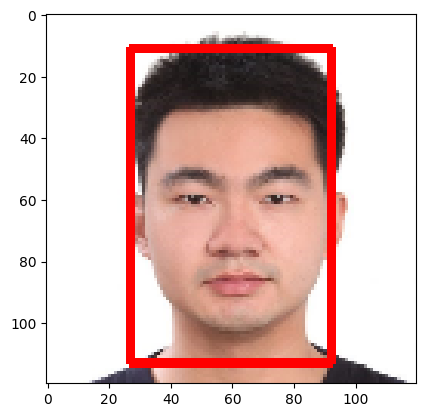

In [4]:
# import the libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# load the image file
image = cv2.imread('checktwo.jpg')
# convert it to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# resize it to the same size as the test images
image = tf.image.resize(image, (120, 120))
# convert the tensor object to a numpy array
image = image.numpy()
# predict the face detection and location
yhat = facetracker.predict(np.expand_dims(image / 255, 0))
# get the prediction score and coordinates
score = yhat[0][0]
coords = yhat[1][0]
# check if the score is greater than 0.9
if score > 0.9:
# draw a rectangle around the face
    cv2.rectangle(image, 
            tuple(np.multiply(coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(coords[2:], [120, 120]).astype(int)), 
                (255, 0, 0), 2)
    # face_image = crop(image, coords)
    # save the face image
    # cv2.imwrite("face.jpg", face_image)
# display the image
plt.imshow(image/255)
plt.show()

### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [182]:
facetracker.save('facetracker.h5')

C:\Users\PMLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
facetracker = load_model('facetracker.h5')

# Convert the Model into TF Lite & Save It

In [184]:
# Load your .h5 file as a Keras model
model = tf.keras.models.load_model("./facetracker.h5")

# Create a converter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert the model to TensorFlow Lite
tflite_model = converter.convert()

# Save the TensorFlow Lite model as a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PMLS\AppData\Local\Temp\tmp2od24c9j\assets


INFO:tensorflow:Assets written to: C:\Users\PMLS\AppData\Local\Temp\tmp2od24c9j\assets


### 11.3 Real Time Detection

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('frame.jpg', frame)
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 119ms/step


In [17]:
cap = cv2.VideoCapture(0)
while True:
    # Read a frame from the camera
    success, frame = cap.read()
    # Check if the reading was successful
    if success:
        # Show the frame on the output window
        cv2.imshow("Camera", frame)
    else:
        # Break the loop if the reading failed
        break
    # Wait for 1 millisecond and get the key code
    key = cv2.waitKey(1)
    # Mask the key code with 0xFF
    key = key & 0xFF
    # Check if the user pressed the 'q' key
    if key == ord('q'):
        # Break the loop
        break

# Release the camera
cap.release()
# Destroy the output window
cv2.destroyAllWindows()